# Predicting cell phenotypes using signaling signatures

In [1]:
import scipy as sp, numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
from numpy import random
from sklearn.cluster import KMeans
from Bio import SeqIO
from distance_calculation import Distance
from collections import defaultdict

## Importing Data

In [4]:
X = np.array(pd.read_csv('./MS_Initial_Data.csv', header=0', header=0))
Y = np.array(pd.read_csv('./Ydata.csv', header=0))
treatments_axl = np.array(pd.read_csv('./MS_Initial_Data.csv', header=None))[0,2:]
treatments_cv = np.delete(treatments_axl,[3,7,8,9])

peptide_phosphosite = X[:,0]
protein_description = X[:,1]
ProtNames = []
for item in protein_description:
    ProtName = item.split("OS")
    ProtName = ProtName[0]
    ProtNames.append(ProtName)
PC9 = X[:,2]
Erl = X[:,3]
R428 = X[:,4]
Erl_R428 = X[:,5]
Erl_HGF = X[:,6]
Erl_FGF = X[:,7]
Erl_IGF = X[:,8]
KO_Erl = X[:,9]
KO_R428 = X[:,10]
KO_Erl_R428 = X[:,11]

# for AXL expression
X_axl = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X_axl = np.reshape(X_axl,(10,300))
Y_axl = Y[:,3]
Y_axl = Y_axl[:10]

# for cell viability
X_cv = np.concatenate([PC9,Erl,R428,Erl_HGF,Erl_FGF,Erl_IGF])
X_cv = np.reshape(X_cv,(6,300))
Y_cv = Y[:,2]
del_cv1 = [3] 
del_cv2 = list(np.arange(7,54))
del_cv = del_cv1 + del_cv2
Y_cv = np.delete(Y_cv,[del_cv])

/Users/zoekim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


## Preprocessing Data

Z-score Y vectors for AXL Expression and Cell Viability and their corresponding X matrices by treatment.

In [5]:
Y_axl_z = sp.stats.zscore(Y_axl)
Y_cv_z = sp.stats.zscore(Y_cv)

def zscore_columns(matrix):
    matrix_z = np.zeros((matrix.shape[0],matrix.shape[1]))
    for a in range(matrix.shape[1]):
        column = []
        column = matrix[:,a]
        column_mean = np.mean(column)
        column_std = np.std(column)
        matrix_z[:,a] = np.asmatrix([(column-column_mean)/column_std])
    return matrix_z

X_axl_z = np.array(zscore_columns(X_axl.copy()))
X_cv_z = np.array(zscore_columns(X_cv.copy()))

## Determining Number of Components

Below, R2Y and Q2Y are plotted across a number of PLSR components for both AXL Expression and Cell Viability. Note that R2Y is maximized at 8 components for AXL Expression and 4 components for Cell Viability. However, 3 components were picked for both models, as increases in R2Y become relatively insignificant past this point.

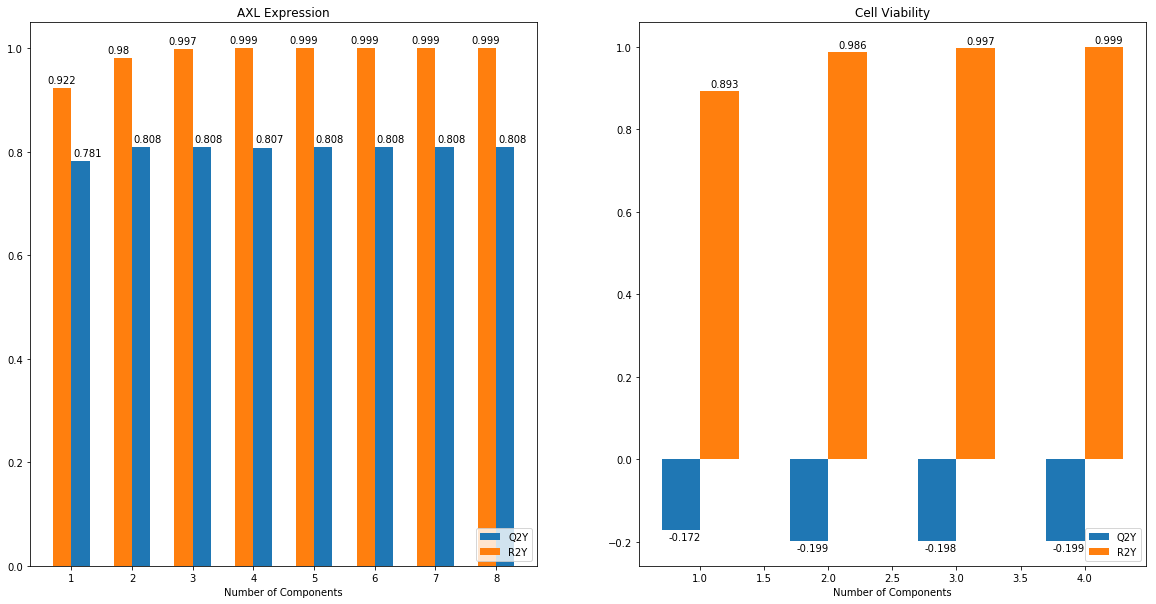

In [6]:
def R2Y_across_components(X_z,Y_z,max_comps,sublabel):
    R2Ys = []
    components = []
    for b in range(1,max_comps):
        plsr = PLSRegression(n_components = b)
        X_scores, Y_scores = plsr.fit_transform(X_z,Y_z)
        R2Y = plsr.score(X_z,Y_z)
        R2Ys.append(R2Y)
        components.append(b)
    return R2Ys

loo = LeaveOneOut()

def Q2Y_across_components(X_z,Y_z,max_comps,sublabel):
    PRESS = 0
    SS = 0
    Q2Ys = []
    for b in range(1,max_comps):
        plsr_model = PLSRegression(n_components = b)
        for train_index, test_index in loo.split(X_z, Y_z):
            X_train, X_test = X_z[train_index], X_z[test_index]
            Y_train, Y_test = Y_z[train_index], Y_z[test_index]
            X_train = zscore_columns(X_train)
            Y_train = sp.stats.zscore(Y_train)
            plsr_model.fit_transform(X_train,Y_train)
            Y_predict_cv = plsr_model.predict(X_test)
            PRESS_i = (Y_predict_cv - Y_test) ** 2
            SS_i = (Y_test) ** 2
            PRESS = PRESS + PRESS_i
            SS = SS + SS_i
        Q2Y = 1 - (PRESS/SS)
        Q2Ys.append(Q2Y)
    return Q2Ys
        
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,ax,spac1,spac2,dec):
    for l, m in enumerate(x):
        axs[ax].text(l+spac1,m+spac2,str(truncate(m,dec)))

Q2Y_axl = np.squeeze(Q2Y_across_components(X_axl_z,Y_axl_z,9,'AXL Expression'))
Q2Y_cv = np.squeeze(Q2Y_across_components(X_cv_z,Y_cv_z,5,'Cell Viability')) 
R2Y_axl = R2Y_across_components(X_axl_z,Y_axl_z,9,'AXL Expression')
R2Y_cv = R2Y_across_components(X_cv_z,Y_cv_z,5,'Cell Viability') 
range_axl = np.linspace(1,8,8)
range_cv = np.linspace(1,4,4)

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].bar(range_axl+0.15,Q2Y_axl,width=0.3,align='center',label='Q2Y')
axs[0].bar(range_axl-0.15,R2Y_axl,width=0.3,align='center',label='R2Y')
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axl,0,1.03,0.01,3)
disp_values(R2Y_axl,0,0.6,0.01,3)
axs[1].bar(range_cv-0.15,Q2Y_cv,width=0.3,align='center',label='Q2Y')
axs[1].bar(range_cv+0.15,R2Y_cv,width=0.3,align='center',label='R2Y')
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cv,1,0.75,-0.025,3)
disp_values(R2Y_cv,1,1.075,0.01,3)
axs[1].legend(loc=4)
plt.show()

## Running PLSR for Each Phenotype

PLSR with three components is run for both AXL Expression and Cell Viability, and the corresponding scores and loadings data is organized.

In [7]:
plsr_axl = PLSRegression(n_components = 3)
X_scores_axl, Y_scores_axl = plsr_axl.fit_transform(X_axl_z,Y_axl_z)
PC1_scores_axl, PC2_scores_axl = X_scores_axl[:,0], X_scores_axl[:,1]
PC1_xload_axl, PC2_xload_axl = plsr_axl.x_loadings_[:,0], plsr_axl.x_loadings_[:,1]
PC1_yload_axl, PC2_yload_axl = plsr_axl.y_loadings_[:,0], plsr_axl.y_loadings_[:,1]

plsr_cv = PLSRegression(n_components = 3)
X_scores_cv, Y_scores_cv = plsr_cv.fit_transform(X_cv_z,Y_cv_z)
PC1_scores_cv, PC2_scores_cv = X_scores_cv[:,0], X_scores_cv[:,1]
PC1_xload_cv, PC2_xload_cv = plsr_cv.x_loadings_[:,0], plsr_cv.x_loadings_[:,1]
PC1_yload_cv, PC2_yload_cv = plsr_cv.y_loadings_[:,0], plsr_cv.y_loadings_[:,1]

For the generated PLSR models, plots of the actual versus predicted values are generated.

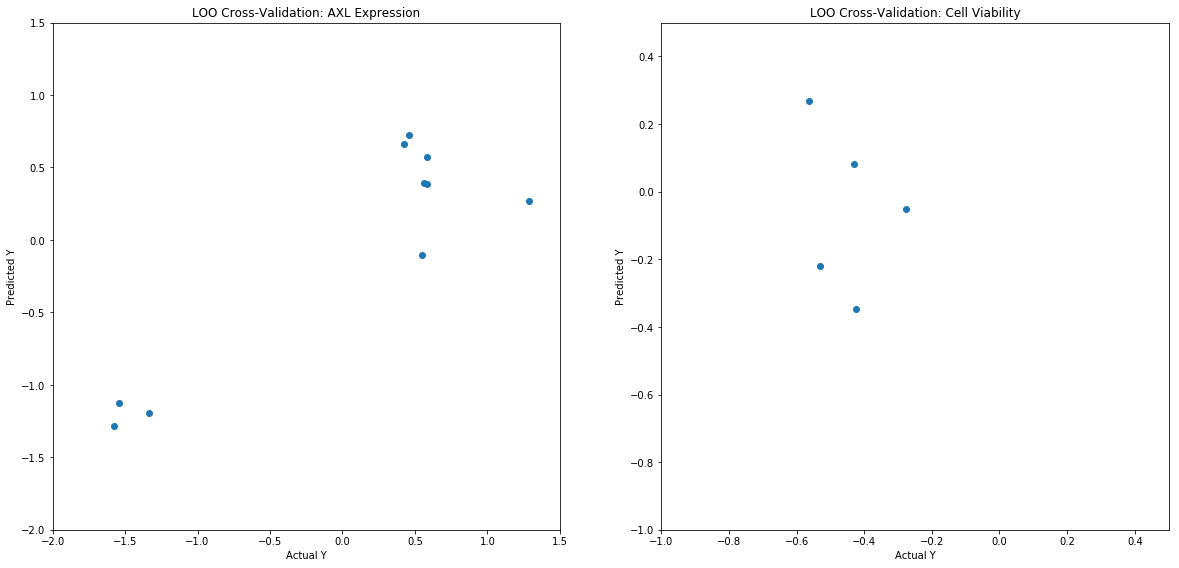

In [8]:
def cross_validation_plot(X,Y,plsr_model,ax,subtitle):
    Y_predictions = []
    for train_index, test_index in loo.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        X_train = zscore_columns(X_train)
        Y_train = sp.stats.zscore(Y_train)
        plsr_model.fit_transform(X_train,Y_train)
        Y_predict = plsr_model.predict(X_test)
        Y_predictions.append(Y_predict)
    axs[ax].scatter(Y,np.squeeze(Y_predictions))
    axs[ax].set(title=subtitle,xlabel='Actual Y',ylabel='Predicted Y')

fig, axs = plt.subplots(1,2,figsize=(20,10))
cross_validation_plot(X_axl_z,Y_axl_z,plsr_axl,0,'LOO Cross-Validation: AXL Expression')
axs[0].set_xlim([-2, 1.5])
axs[0].set_ylim([-2, 1.5])
axs[0].set_aspect('equal')
cross_validation_plot(X_cv_z,Y_cv_z,plsr_cv,1,'LOO Cross-Validation: Cell Viability')
axs[1].set_xlim([-1, 0.5])
axs[1].set_ylim([-1, 0.5])
axs[1].set_aspect('equal')
plt.show()

## Clustering by Sequence Similarity

The peptide sequences are sliced to only the three amino acids on each side of phosphorylation site. Missing amino acids within this range are assigned randomly. Then, a PAM250 matrix is used to calculate distances between the sequences. From the resultant distance matrix, k-means is used to form 25 clusters.

In [9]:
amino_acids = ['A','R','N','D','B','C','E','Q','Z','G','H','I','L','K','M','F','P','S','T','W','Y','V']

def surrounding_three(sequences):
    bracket3 = []
    for g in range(len(sequences)):
        for h in range(len(sequences[g])):
            if (sequences[g])[h] == 'y':
                surround = ''
                for i in range(-3,4):
                    if (h+i) < 0:
                        surround = surround + random.choice(amino_acids)
                    elif (h+i) == h:
                        surround = surround
                    elif peptide_phosphosite[g][h+i] == '-' or peptide_phosphosite[g][h+i] == '0' or peptide_phosphosite[g][h+i] == '1':
                        surround = surround + random.choice(amino_acids)
                    else:
                        surround = surround + (peptide_phosphosite[g][h+i])
        bracket3.append(surround.upper())
    return bracket3

peptide_phosphosite_3 = surrounding_three(peptide_phosphosite)

# for generating fasta file
"""
for i in range(len(peptide_phosphosite_3)):
    print('>seq%d' % (i))
    print(peptide_phosphosite_3[i])
print(np.squeeze(peptide_phosphosite_3))
"""

"\nfor i in range(len(peptide_phosphosite_3)):\n    print('>seq%d' % (i))\n    print(peptide_phosphosite_3[i])\nprint(np.squeeze(peptide_phosphosite_3))\n"

In [10]:
D_PAM = Distance("trial_seq.fa", "PAM250")
distMat = D_PAM.dist_mat()

kmeans = KMeans(n_clusters=25)
kmeans.fit(distMat)
clusters = kmeans.fit_predict(distMat)   #list of cluster assignments across 300 kinases

using path from windows machine to load sequences
calculating the full distance matrix based on PAM250


## Results: AXL Expression

The scores and loadings plots for the three-component PLSR model are displayed, with the final loadings plot indicating cluster by color.

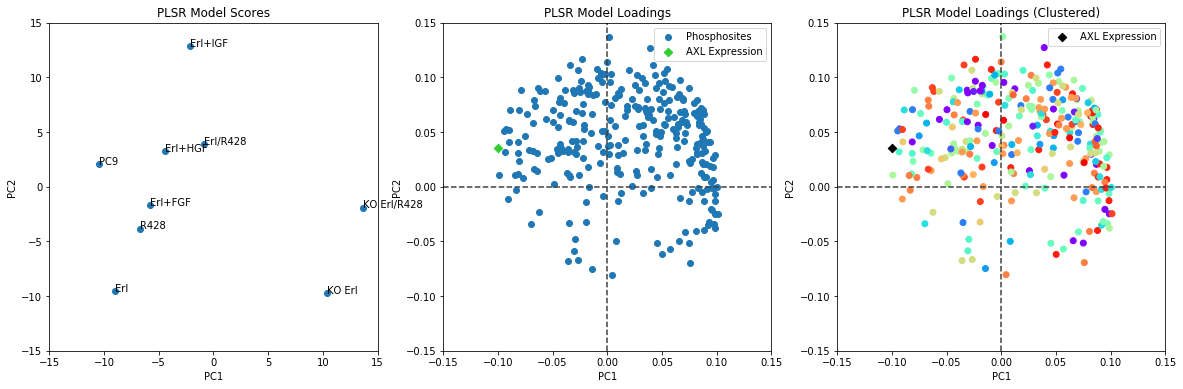

In [11]:
fig, axs = plt.subplots(1, 3,figsize=(20,10))
axs[0].scatter(PC1_scores_axl,PC2_scores_axl)
for j, txt in enumerate(treatments_axl):
    axs[0].annotate(txt, (PC1_scores_axl[j], PC2_scores_axl[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_xlim([-15, 15])
axs[0].set_ylim([-15, 15])
axs[0].set_aspect('equal')
axs[1].scatter(PC1_xload_axl,PC2_xload_axl, label='Phosphosites')
axs[1].scatter(PC1_yload_axl,PC2_yload_axl, color='#32CD32', marker='D', label='AXL Expression')
axs[1].set_title('PLSR Model Loadings')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_xlim([-0.15, 0.15])
axs[1].set_ylim([-0.15, 0.15])
axs[1].set_aspect('equal')
axs[1].legend()
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
colors_ = cm.rainbow(np.linspace(0, 1, 25))
axs[2].scatter(PC1_xload_axl, PC2_xload_axl, c=clusters, cmap=colors.ListedColormap(colors_))
axs[2].scatter(PC1_yload_axl, PC2_yload_axl, color='#000000', marker='D', label='AXL Expression')
axs[2].legend()
axs[2].set_title('PLSR Model Loadings (Clustered)')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].set_xlim([-0.15, 0.15])
axs[2].set_ylim([-0.15, 0.15])
axs[2].set_aspect('equal')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
plt.show()

## Results: Cell Viability

Similarly, the same plots are displayed for the three-component cell viability PLSR model.

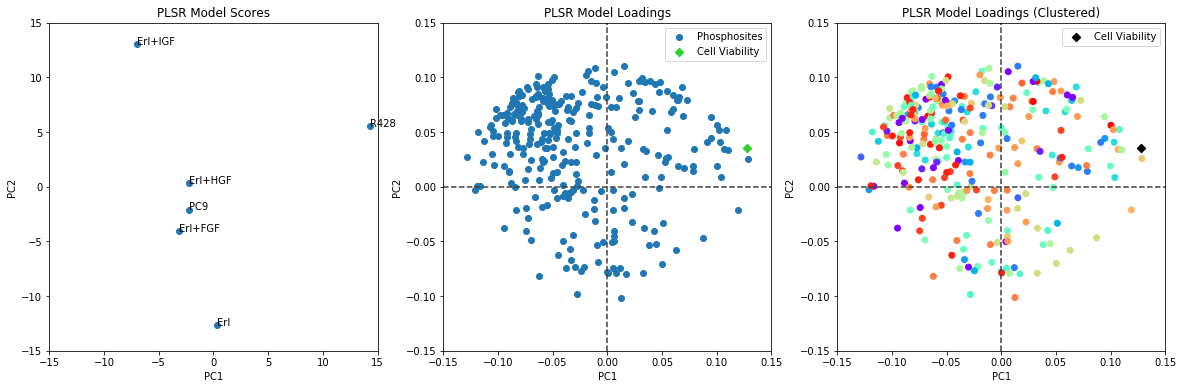

In [12]:
fig, axs = plt.subplots(1, 3,figsize=(20,10))
axs[0].scatter(PC1_scores_cv,PC2_scores_cv)
for k, txt_ in enumerate(treatments_cv):
    axs[0].annotate(txt_, (PC1_scores_cv[k], PC2_scores_cv[k]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_xlim([-15, 15])
axs[0].set_ylim([-15, 15])
axs[0].set_aspect('equal')
axs[1].scatter(PC1_xload_cv,PC2_xload_cv, label='Phosphosites')
axs[1].scatter(PC1_yload_cv,PC2_yload_cv, color='#32CD32', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_xlim([-0.15, 0.15])
axs[1].set_ylim([-0.15, 0.15])
axs[1].set_aspect('equal')
axs[1].legend()
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[2].scatter(PC1_xload_cv, PC2_xload_cv, c=clusters, cmap=colors.ListedColormap(colors_))
axs[2].scatter(PC1_yload_cv, PC2_yload_cv, color='#000000', marker='D', label='Cell Viability')
axs[2].legend()
axs[2].set_title('PLSR Model Loadings (Clustered)')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].set_xlim([-0.15, 0.15])
axs[2].set_ylim([-0.15, 0.15])
axs[2].set_aspect('equal')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
plt.show()

##  Reimplementation of PLSR using Cluster Averages

Since PLSR is unreliable with the amount of variables relative to observations in this dataset, reduction of variables is attempted by averaging phosphorylation measurements across each of the 25 clusters generated by the PAM 250 sequence clustering.

In [13]:
def ClusterAverages(X_, nObs):
    ClusterAvgs = []
    DictClusterToAvgs = {}
    DictClusterToPhosphoName = {}
    ClusterAvgs_arr = np.zeros((25,nObs))
    for i in range(25):
        CurrentCluster = []
        Names = []
        for idx, arr in enumerate(X_):
            if i == arr[0]:
                CurrentCluster.append(arr)
                Names.append(ProtNames[idx])
        DictClusterToPhosphoName[i] = Names
        CurrentCluster_T = np.transpose(CurrentCluster)
        CurrentAvgs = []
        for x, arr in enumerate(CurrentCluster_T):
            if x == 0:
                continue
            else:
                avg = np.mean(arr)
                CurrentAvgs.append(avg)
        DictClusterToAvgs[i] = CurrentAvgs
        ClusterAvgs_arr[i,:] = CurrentAvgs
        AvgsArr = np.transpose(ClusterAvgs_arr)
    return AvgsArr, DictClusterToPhosphoName

In [14]:
X_axl_wCl = np.insert(X_axl, 0, clusters, axis = 0)
X_axl_xClT = np.transpose(X_axl_wCl)

Cluster_Avgs_Axl,x = ClusterAverages(X_axl_xClT, 10)
X_ClusterAvgsAXL_z = zscore_columns(Cluster_Avgs_Axl)

X_cv_wCl = np.insert(X_cv, 0, clusters, axis = 0)
X_cv_xClT = np.transpose(X_cv_wCl)

Cluster_Avgs_cv, x = ClusterAverages(X_cv_xClT, 6)
X_ClusterAvgsCV_z = zscore_columns(Cluster_Avgs_cv)

The names of the proteins contained in each cluster are displayed.

In [15]:
x, DictClusterToPhosphoName = ClusterAverages(X_axl_xClT, 10)

print("{:<8} {:<20}".format('Cluster','Protein Name'))
counter = 0
for k, v in DictClusterToPhosphoName.items():
    for idx in range(len(v)):
        print("{:<8} {:<20}".format(k+1, v[idx]))
        counter +=1
assert ((counter) == 300), "Check function"

Cluster  Protein Name        
1        Rho guanine nucleotide exchange factor 5 
1        Enhancer of filamentation 1 
1        Protein LAP2        
1        Ankyrin repeat and SAM domain-containing protein 1A 
1        Keratin, type I cytoskeletal 19 
1        Protein LAP2        
1        FYN-binding protein 
1        Integrin beta-4     
1        Protein-tyrosine kinase 2-beta 
1        Spectrin alpha chain, non-erythrocytic 1 
1        Glucose-6-phosphate 1-dehydrogenase 
1        Actin filament-associated protein 1-like 2 
1        Receptor-interacting serine/threonine-protein kinase 1 
1        Insulin-like growth factor 1 receptor 
1        40S ribosomal protein SA 
1        Plakophilin-3       
1        Tyrosine-protein kinase Lyn 
1        Integrin beta-4     
1        Tyrosine-protein kinase Lck 
1        Tyrosine-protein kinase Lck 
1        Tensin-3            
1        Atypical chemokine receptor 3 
1        Tensin-3            
2        Heat shock protein HSP 90-beta 
2  

PLSR with 3 components is re-implemented using the cluster averages as the variables.

In [16]:
plsr_axlC = PLSRegression(n_components = 3)
X_scores_axlC, Y_scores_axlC = plsr_axlC.fit_transform(X_ClusterAvgsAXL_z,Y_axl_z)
PC1_scores_axlC, PC2_scores_axlC = X_scores_axlC[:,0], X_scores_axlC[:,1]
PC1_xload_axlC, PC2_xload_axlC = plsr_axlC.x_loadings_[:,0], plsr_axlC.x_loadings_[:,1]
PC1_yload_axlC, PC2_yload_axlC = plsr_axlC.y_loadings_[:,0], plsr_axlC.y_loadings_[:,1]

plsr_cvC = PLSRegression(n_components = 3)
X_scores_cvC, Y_scores_cvC = plsr_cvC.fit_transform(X_ClusterAvgsCV_z, Y_cv_z)
PC1_scores_cvC, PC2_scores_cvC = X_scores_cvC[:,0], X_scores_cvC[:,1]
PC1_xload_cvC, PC2_xload_cvC = plsr_cvC.x_loadings_[:,0], plsr_cvC.x_loadings_[:,1]
PC1_yload_cvC, PC2_yload_cvC = plsr_cvC.y_loadings_[:,0], plsr_cvC.y_loadings_[:,1]

Below are the results of the actual versus predicted Y's using leave one out cross-validation.

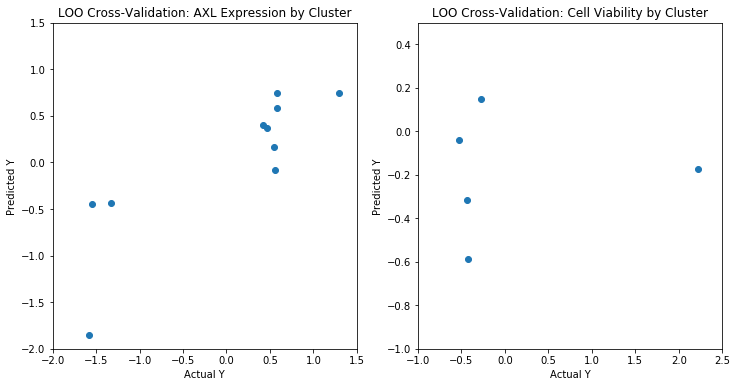

In [17]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_ClusterAvgsAXL_z,Y_axl_z,plsr_axl,0,'LOO Cross-Validation: AXL Expression by Cluster')
axs[0].set_xlim([-2, 1.5])
axs[0].set_ylim([-2, 1.5])
cross_validation_plot(X_ClusterAvgsCV_z,Y_cv_z,plsr_cv,1,'LOO Cross-Validation: Cell Viability by Cluster')
axs[1].set_xlim([-1, 2.5])
axs[1].set_ylim([-1, 0.5])
plt.show()

### Results: AXL Expression

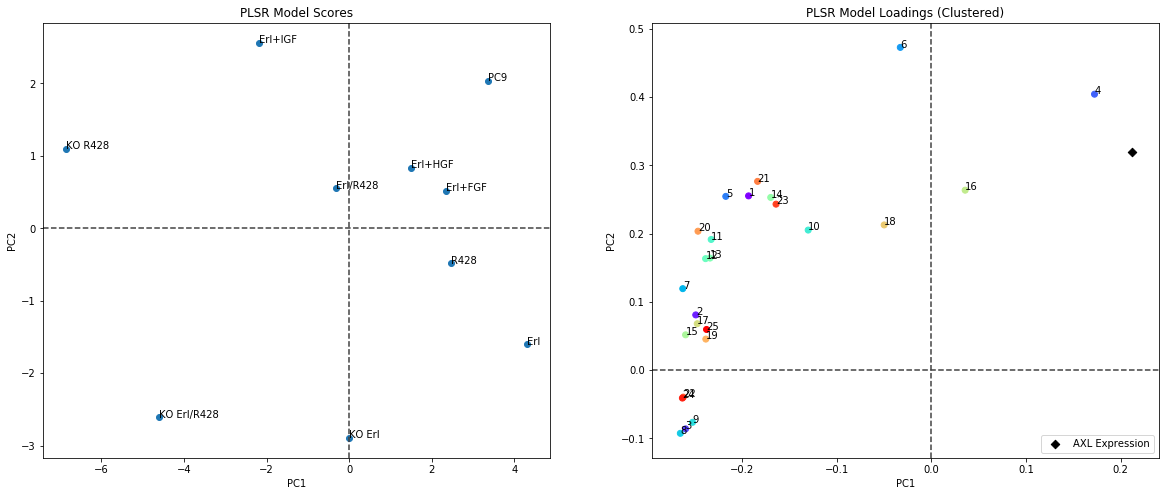

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(20,8))
colors_ = cm.rainbow(np.linspace(0, 1, 25))
axs[0].scatter(PC1_scores_axlC,PC2_scores_axlC)
for j, txt in enumerate(treatments_axl):
    axs[0].annotate(txt, (PC1_scores_axlC[j], PC2_scores_axlC[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[1].scatter(PC1_xload_axlC, PC2_xload_axlC, c=np.arange(25), cmap=colors.ListedColormap(colors_))
cl = []
for i in range(25):
    i += 1
    Var = str(i)
    cl.append(Var)
cls = np.array(cl)
for j, txt in enumerate(cls):
    axs[1].annotate(txt, (PC1_xload_axlC[j], PC2_xload_axlC[j]))
axs[1].scatter(PC1_yload_axlC, PC2_yload_axlC, color='#000000', marker='D', label='AXL Expression')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Clustered)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
plt.show()

### Results: Cell Viability

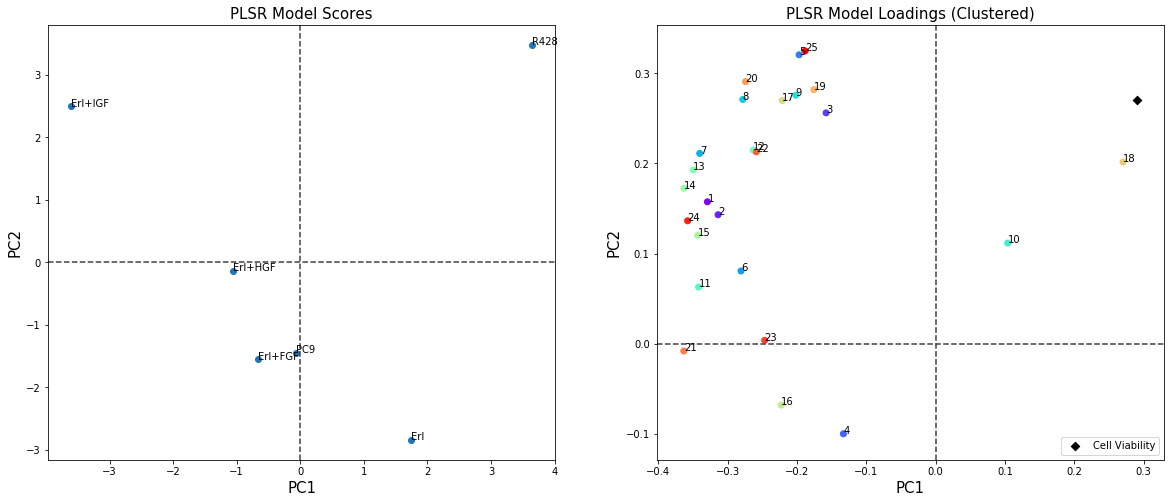

In [20]:
fig, axs = plt.subplots(1, 2,figsize=(20,8))
colors_ = cm.rainbow(np.linspace(0, 1, 25))
axs[0].scatter(PC1_scores_cvC,PC2_scores_cvC)
for j, txt in enumerate(treatments_cv):
    axs[0].annotate(txt, (PC1_scores_cvC[j], PC2_scores_cvC[j]))
axs[0].set_title('PLSR Model Scores', fontsize = 15)
axs[0].set_xlabel('PC1', fontsize = 15)
axs[0].set_ylabel('PC2', fontsize = 15)
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[1].scatter(PC1_xload_cvC, PC2_xload_cvC, c=np.arange(25), cmap=colors.ListedColormap(colors_))
cl = []
for i in range(25):
    i += 1
    Var = str(i)
    cl.append(Var)
cls = np.array(cl)
for j, txt in enumerate(cls):
    axs[1].annotate(txt, (PC1_xload_cvC[j], PC2_xload_cvC[j]))
axs[1].scatter(PC1_yload_cvC, PC2_yload_cvC, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Clustered)', fontsize = 15)
axs[1].set_xlabel('PC1', fontsize = 15)
axs[1].set_ylabel('PC2', fontsize = 15)
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
plt.show()